# **Project Goals**

The goal of the project would be as follows:

1: Write your own code (not an existing repo on the internet) that performs single shot ptychography using structured illumination as demonstrated in the papers by Levitan et al.

2: answer the following question:

a. What happens if the illumination (=probe) field has zero crossings? Is this a problem for the method? Do zero crossing result in non-measured points?

b. suppose the method is simulated using 2x2 upsampling (that is, 2x2 probe pixels determine the average phase in a 1x1 super-pixel inside the object). Is it required that there is a relative phase shift between the 2x2 pixels inside the probe? Or can the modulation be amplitude-only (that is no phase shift, but an intensity variation)

c. What is the minimum amount of upsampling needed?

d. Is there a class of illumination functions for which the method fails?

e. Try implementing regularization to the method. Please include L1, L2, and Total variation regularization.

# **Project Ptychography**

Illumination: A grid of partially overlapping beams, each beam approaches the sample from different angles. 

Reconstruction: Randomized probe imaging algorithm. 

General strategy: Divide the intensity pattern into a collection of individual, smaller diffraction patterns. The smaller patterns are centered on an individual beam and tagged with a corresponding translation at the same plane.

X-ray problem: Difficult to generate a grid of identical beams with sufficient angular separation and uniform intensities. Grating equation: $d(
\sin\theta_m) = m\lambda$. Small wavelength leads to small grating period.

Feature: It recovers both the probe and the object, so the probe is not needed to be known. But the division of the detector limits resolution by limiting the NA

Method used in the single-shot article:

A purely iterative algorithm for single-shot ptychography which uses a pre-calibrated probe and operates on full diffraction patterns without partitioning them into a ptychography dataset.

This method overcomes limitations of the general strategy that in cases where the object contains high frequency components, the scattering from neighboring beams does overlap and interfere, causing reconstructions to perform poorly.

The forward model for this algorithm:

$$I = \sum_{n=1}^{N} \left| \mathcal{F} \left\{ P_n \cdot \mathcal{F}^{-1} \left\{ \mathcal{U} \cdot \mathcal{F} \left\{\exp(i T)\right\} \right\} \right\} \right|^2$$

$P_n$ is the discrete representation= of the nth mode of the pre-calibrated probe. $\mathcal{U} is a zero padding operator, and $T$ is a low-resolution representation of the object's transmission function

Zero-padding $\mathcal{U}$ is a band-limiting constraint that stablizes the inverse problem.

$T$ is constraint to be purely real to apply an additional phase-only constraint on the object. Allowing $T$ to be complex-valued can remove the phase-only constraint. The final object function is defined as:

$$ O = \exp(iT)$$

The first step of the model is to upsample the low-resolution object $O$ by padding it with zeros in Fourier space

In [120]:
import h5py
import matplotlib.pyplot as plt
import jax.numpy as jnp

In [121]:
def probe_generation():

    pass

def probe_read(filepath=r'Papercode\reconstructions\e17965_1_00678_ptycho_reconstruction.h5'):
    with h5py.File(filepath, 'r') as f:
        # print("Keys in the file:", list(f.keys()))
        dataset = f['probe']
        probe = jnp.array(dataset[:])  # 读取整个数据集
        # there are two probe modes
        return probe

In [122]:
def down_sampling_fre(obj, f=2):
    '''
        down sampling the obj with factor f in Fourier space
    '''
    m, n = obj.shape
    obj_fre = jnp.fft.fftshift(jnp.fft.fft2(obj))
    m_d, n_d = m // f, n // f # downsampling size
    
    m_center ,n_center = m // 2, n // 2 # original center
    m_d_half, n_d_half = n_d // 2, m_d // 2
    
    #index of cropped area
    m_start = m_center - m_d_half
    m_end = m_start + m_d
    n_start = n_center - n_d_half
    n_end = n_start + n_d
    
    obj_fre_cropped = obj_fre[m_start:m_end, n_start:n_end]
    
    obj_downSampled = jnp.fft.ifft2(jnp.fft.ifftshift(obj_fre_cropped))
    return obj_downSampled
    
    
def down_sampling_spa(obj,f=2):
    '''
        down sampling the obj with factor f in spatial domain
        block averaging is employed, average amplitude and phase
    '''
    m, n = obj.shape
    
    # crop obj to ensure integer times with the factor
    m_crop = (m // f) * f
    n_crop = (n // f) * f
    obj_cropped = obj[:m_crop, :n_crop]

    reshaped = obj_cropped.reshape(m_crop // f, f, n_crop // f, f)
    obj_downSampled = reshaped.mean(axis=(1, 3))
    
    return obj_downSampled

In [123]:
def pad_array(array, pad_array):
    pad_factortb = jnp.abs((jnp.shape(pad_array)[0] - jnp.shape(array)[0])) // 2
    pad_factorrl = jnp.abs((jnp.shape(pad_array)[1] - jnp.shape(array)[1])) // 2
    paded_array = jnp.pad(array, ((pad_factortb, pad_factortb),(pad_factorrl, pad_factorrl)))
    return paded_array

In [124]:
def forward_model(obj, probe, f=2):
    '''
        the forward model generates the update diffraction field from the down sampled obj
        in this simulation assumes only one probe 
    '''
    obj_downSampled = down_sampling_fre(obj, f=2)
    obj_fre = jnp.fft.fftshift(jnp.fft.fft2(obj_downSampled))
    obj_frepad = pad_array(obj_fre, probe[0,:,:])
    obj_pad = jnp.fft.ifft2(jnp.fft.ifftshift(obj_frepad))
    update_diff_pattern0 = jnp.abs(
        jnp.fft.fftshift(jnp.fft.fft2((probe[0, :, :] * 0.756) * obj_pad)))**2
    update_diff_pattern1 = jnp.abs(
        jnp.fft.fftshift(jnp.fft.fft2((probe[1, :, :] * 0.244) * obj_pad)))**2
    update_diff_pattern = update_diff_pattern0 + update_diff_pattern1

    return update_diff_pattern

## **Reconstruction**

To perform a reconstruction, we start with an initial guess of the project function and use a forward model to simulate the corresponding diffraction pattern. 

Next, we calculate the normalized mean squared error between the measured diffraction amplitudes and a simulated diffraction pattern including a known detector background:

$$ L = \frac{1}{\sum_{ij}I_{ij}} \sum_{ij}\left( \sqrt{|\tilde{E_{ij}}|^2 + B_{ij}} - \sqrt{I_{ij}}\right)^2$$

From the equation above, we can write it in Python:

In [125]:
import jax.numpy as jnp
from chex import assert_equal_shape

def loss_function(simulated: jnp.ndarray, background: jnp.ndarray, measured: jnp.ndarray) -> float:
    '''
    Calculates the normalized mean squared error (L) for the given simulated diffraction amplitudes E, detector background B, and the measured diffraction pattern I.

    Args: 
        simulated (jnp.ndarray): The simulated diffraction pattern (Intensity) calculated from a forward model
        backgroud (jnp.ndarray): The detector background (Intensity)
        I (jnp.ndarray): The measured diffraction pattern (Intensity)
    
    Return:
        float: The normalized mean squared error (L) 
    '''
    # Assert that the three arrays have the same shape
    assert_equal_shape([simulated, background, measured])

    # Calculate the factor to normalize the error
    factor = 1.0 / (jnp.sum(measured) + 1e-10)

    # Calculate the simulated diffraction amplitudes
    simulated_amp = jnp.sqrt(simulated + background)

    # Calculate the measured diffraction amplitudes
    measured_amp = jnp.sqrt(measured)

    # Calculate the normalized mean squared error
    loss = factor * jnp.sum((simulated_amp - measured_amp) ** 2)

    return loss

Example usage:

In [126]:
simulated = jnp.array([[1.0, 2.0], [3.0, 4.0]])  # Simulated amplitudes (complex or real)
background = jnp.array([[0.1, 0.1], [0.1, 0.1]])   # Background
measured = jnp.array([[1.5, 4.5], [9.5, 16.5]])   # Measured intensities

print("loss =", loss_function(simulated, background, measured))

loss = 0.19935277


We then use automatic differentiation to calculate the Wirtinger derivative of the loss function with respect to the object guess $T$:

$$ \frac{\delta L}{\delta T} = \frac{\delta L}{\delta |E_{ij}|^2} \frac{\delta |E_{ij}|^2}{\delta T}$$

In [127]:
from jax import grad

def derivative_loss_function_wrt_obj(obj: jnp.ndarray, measured: jnp.ndarray, background: jnp.ndarray, probe: jnp.ndarray) -> jnp.ndarray:
    '''
    Calculates the Wirtinger derivative of the loss function with respect to the object guess obj.

    Args:
        obj (jnp.ndarray): The object guess (complex or real)

    Return:
        jnp.ndarray: The derivative of the loss function with respect to the object guess obj
    '''
    def loss_wrt_obj(obj, probe):
        simulated = forward_model(obj, probe)
        return loss_function(simulated, background, measured)
    return grad(loss_wrt_obj)(obj, probe)

Then, we feed those derivatives into an update for the object guess $T_{guess}$ using the Adam algorithm. This process is repeated iteratively until the object converges.

Adam is short for Adaptive Moment Estimation. It's a popular optimization algorithm used in machine learning to train models like neural networks. It's a type of stochastic gradient descent (SGD) that adapts the learning rate for each parameter.

Adam maintains two moving averages for each parameter $\theta$:

1.First Moment (Mean): An estimate of the gradient, similar to momentum, denoted as:
$$ m_{t} = \beta_{1}m_{t-1} + (1 - \beta_1)g_t $$
where $g_t$ is the gradient at time step t, and $\beta_1$ is typically set to 0.9.

2.Second Moment (Variance): An estimate of the squared gradient, similar to RMSprop, denoted as:
$$ v_t = \beta_2v_{t-1} + (1-\beta_2)g_t^2$$
where $\beta_2$ is typically set to 0.999.

The bias-corrected first and second moments are: 
$$ \hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$
$$ \hat{v}_t = \frac{v_t}{1-\beta_2^t}$$

The parameter update rule is then:

$$ \theta_{t+1} = \theta_t - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$

 where $\alpha$ is the learning rate, $\epsilon$ is a small constant to prevent division by zero, and $t$ is the current iteration.

In [128]:
import optax

def adam_optimization(init_obj: jnp.ndarray, measured: jnp.ndarray, background: jnp.ndarray, probe: jnp.ndarray, learning_rate: float, num_iterations: int) -> jnp.ndarray:
    '''
    Optimizes the object guess using the Adam optimizer.

    Args:
        init_obj (jnp.ndarray): The initial object guess (complex or real)
        measured (jnp.ndarray): The measured diffraction pattern (Intensity)
        learning_rate (float): The learning rate
        num_iterations (int): The number of optimization iterations

    Return:
        jnp.ndarray: The optimized object guess
    '''
    # Initialize the Adam optimizer, beta_1 and beta_2 are default as 0.9 and 0.999 respectively
    optimizer = optax.adam(learning_rate)

    # Initialize the state of the optimizer
    opt_state = optimizer.init(init_obj)

    obj = init_obj                       
    for _ in range(num_iterations):
        # Calculate the gradient of the loss function wrt the object guess
        grad_obj = derivative_loss_function_wrt_obj(obj, measured, background, probe)

        # Update the optimizer state
        updates, opt_state = optimizer.update(grad_obj, opt_state, obj)

        # Update the object guess
        obj = optax.apply_updates(obj, updates)

    return obj

In [129]:
def data_read(filepath=r'Papercode\cxi_files\e17965_1_00677.cxi'):
    with h5py.File(filepath, 'r') as f:
        data = f['entry_1/data_1/data'][:]
        data = jnp.sum(data,axis=0)
    return data

In [130]:
data = data_read()
probe = probe_read()
filename = r'Papercode\reconstructions\e17965_1_00677_ptycho_reconstruction.h5'
with h5py.File(filename, 'r') as f:
    bcg = jnp.array(f['background'][:])


In [131]:
import jax.random as jran
#initilize
# initial_data = data * np.exp(1j * np.random.uniform(0, 2*np.pi, size=data.shape))
key = jran.PRNGKey(0)
key_real, key_imag = jran.split(key)
real_part = jran.normal(key_real, shape=jnp.shape(data))
imag_part = jran.normal(key_imag, shape=jnp.shape(data))
initial_obj_guess = real_part + 1j * imag_part
obj = jnp.copy(initial_obj_guess)

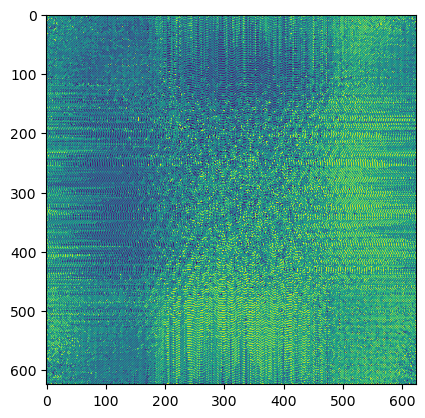

In [132]:
update_obj = adam_optimization(init_obj = obj, measured = data, background = bcg, probe = probe, learning_rate = 0.4, num_iterations = 1000)
plt.imshow(jnp.angle(update_obj))